In [16]:
import os
import spei as sp #spei package
import xarray as xr
import numpy as np
import pandas as pd
import scipy.stats as scs
from joblib import Parallel, delayed
import multiprocessing
import mhm_dataprocessing as md
import geopandas as gpd
from tqdm import tqdm  # pip install tqdm
import matplotlib.pyplot as plt
import xarray as xr
import rioxarray as rio
from itertools import product
import mhm_drought_funcs as mdf

In [2]:
src = r'D:/VUB/_data/mHM_EOBS'

#Data already clipped to domain boundaries
pet = xr.open_dataset(f'{src}/pet_UTMx.nc')
pre = xr.open_dataset(f'{src}/pre_UTMx.nc')
spi_3_da = xr.open_dataset(f'{src}/spi_3_hpc.nc') #implemented in the HPC
drought_ADM = pd.read_csv(os.path.join(src, 'results_ADM.txt'), index_col=0, sep="\s+")


#outputs: drought clusters
dCluster = xr.open_dataset(f'{src}/DCluster.nc')
sMI = xr.open_dataset(f'{src}/SMI.nc')
mask = xr.open_dataset(f'{src}/BE_SMI_mask.nc')

#BE shapefile
be_shp = gpd.read_file(r"W:/VUB/_main_research/mHM/mhm_belgium/be_shp/be_joined_epsg_32631.shp")


#### Clip to model domain and simulation period

In [3]:
#clip the Datasets to BE boundary
pet = md.clip_to_region(be_shp, pet)
pre = md.clip_to_region(be_shp, pre)

#slide data to start from 1970
pet = pet.sel(time=slice('1970-01-01', None))
pre = pre.sel(time=slice('1970-01-01', None))

#mask areas with constant values using data variance
pet = pet.where(pet.pet.var(dim='time') > 0.001, drop=False)
pre = pre.where(pre.pre.var(dim='time') > 0.001, drop=False)

#compute water balance (precipitatione excess) for spei
p_excess = pre.pre - pet.pet

In [ ]:
#p_excess to xr dataset
p_excess = p_excess.to_dataset(name='p_excess')
#p_excess.to_netcdf(f'{src}/p_excess_BE_UTMx.nc')
# pre.to_netcdf(f'{src}/pre_BE_UTMx.nc')

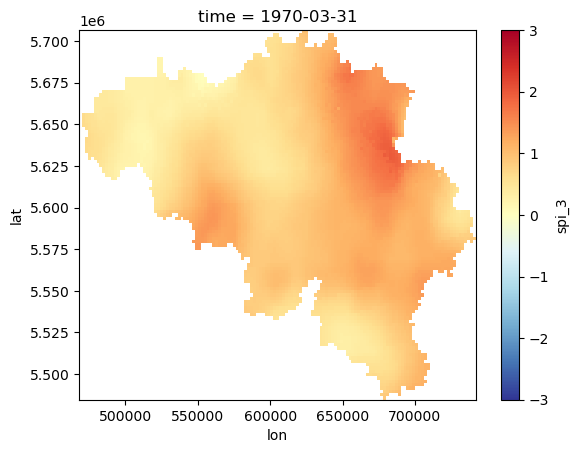

In [5]:
spi_3_da['spi_3'].isel(time=0).plot(cmap='RdYlBu_r', vmin=-3, vmax=3)

#### Clip dCluster to match extent of meteo datasets

In [6]:
#clip dCLuster using pre map
dCluster = dCluster.sel(lat=slice(pre.lat.max(), pre.lat.min()),
                        lon=slice(pre.lon.min(), pre.lon.max()))

#### GRid Cell SPI3

In [ ]:
# Compute SPI for different timescales
spi_1 = mdf.compute_SPI(pre, 'pre', 30)  # SPI-1
#export the SPI-1 to netcdf
spi_1.to_netcdf(f'{src}/spi_1.nc')

#### GridCELL SPEI

In [ ]:
# Compute SPEI for the given timescale
spei_1 = mdf.compute_SPEI(p_excess, 'p_excess', 30)  # SPEI-1
# Export the SPEI-1 to netcdf
spei_1.to_netcdf(f'{src}/spei_1.nc')

In [10]:
#3 month p_excess accumulation
timescale = 30
p_excess_accum = p_excess.rolling(time=timescale).sum()
pre_accum = pre.rolling(time=timescale).sum()

In [ ]:
lat = 5589595.563692  # Example latitude in UTM
lon = 705128.602119  # Example longitude in UTM

p_excess_tx = p_excess_accum.p_excess.sel(lat=lat, lon=lon, method='nearest').to_series().dropna()
precip_tx = pre_accum.pre.sel(lat=lat, lon=lon, method='nearest').to_series().dropna()

spi_3 = sp.spi(precip_tx, dist=scs.gamma, fit_freq="ME")
#spi_3_d = sp.spi(precip_tx, dist=scs.gamma, fit_freq="D")
spei_3 = sp.spei(p_excess_tx, fit_freq="ME")

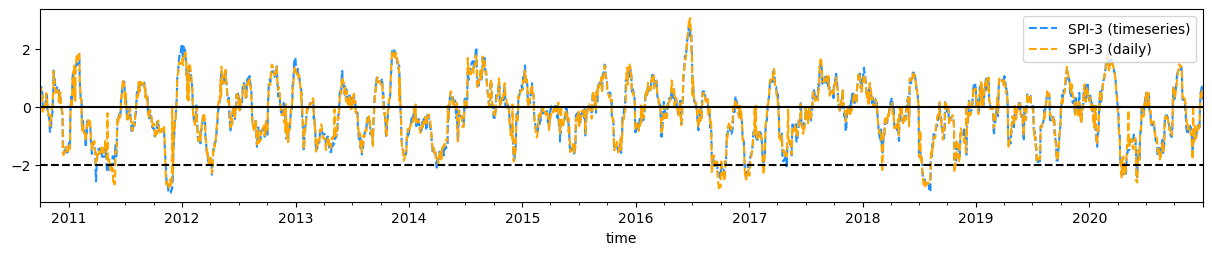

In [13]:
fig, ax = plt.subplots(figsize=(15, 2.5))
startwindow = '2010-10-01'
endwindow='2020-12-31'

#spei_da.sel(lat=lat, lon=lon, method='nearest').to_dataframe().drop(columns=['lat', 'lon'])[startwindow:endwindow].plot(ax=ax, color='blue', label='SPEI-3 (calculated)')
#spei_3[startwindow:endwindow].plot(ax=ax, color='red', ls='--', label='SPEI-3 (calculated)')

# spi_3_da.sel(lat=lat, lon=lon, method='nearest').to_dataframe().drop(columns=['lat', 'lon'])[startwindow:endwindow].plot(ax=ax, c='r')
spi_3[startwindow:endwindow].plot(ax=ax, color='dodgerblue', label='SPI-3 (timeseries)', ls='--')
spi_3_d[startwindow:endwindow].plot(ax=ax, color='orange', label='SPI-3 (daily)', ls='--')

plt.axhline(-2, color='black', ls='--')
plt.axhline(0, color='black', ls='-')
plt.legend()

In [ ]:
dCluster.sel(time=slice('1995-08-01', '1996-08-28'))['mDC'][9].plot()

#### Compare SMI and SPEI

In [ ]:
#cluster IDs of major droughts and their duration
#Assign dates to the drought periods
base_date = datetime(1970, 1, 31) #simulation starts from 1970-01-01, which is mStart=1, so we use 1969-12-31 as the base date

def add_months(months):
    return base_date + relativedelta(months=int(months)-1)

drought_ADM['start_month'] = drought_ADM['mStart'].map(add_months)
drought_ADM['end_month'] = drought_ADM['mEnd'].map(add_months)
drought_ADM.nlargest(8, 'TDM')


,c_Id,mStart,mEnd,aDD,aDA,TDM
i,,,,,,
107,575001,561,575,9.60832,0.64055,9193.14235
20,85003,70,85,10.02164,0.62635,8934.97340
119,638001,627,638,8.39090,0.69924,7870.74532
109,590001,581,590,7.31791,0.73179,7120.87778
60,320001,308,320,7.83329,0.60256,6177.26809
114,613001,604,613,5.79588,0.57959,5782.82654
10,27001,20,27,5.83525,0.72941,5694.67897
96,499003,495,499,4.08251,0.81650,4192.91749
